In [68]:
import patsy
from patsy import dmatrices
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
from sklearn.model_selection import GridSearchCV
import copy
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import sklearn as sk
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier

In [2]:
elo = pd.read_csv('regseason_elo.csv')
elo['team'] = elo['Team']
regdf = pd.read_csv("RegSeasonMod.csv")
regdf.head()

,Season,id,matchid,Daynum,team,Result,score,oppscore,loc,Numot,...,ftm,fta,or,dr,ast,to,stl,blk,pf,oppdr
0,2003,1,2003-1,10,1104,1,68,62,N,0,...,11,18,14,24,13,23,7,1,22,22
1,2003,2,2003-2,10,1272,1,70,63,N,0,...,10,19,15,28,16,13,4,4,18,25
2,2003,3,2003-3,11,1266,1,73,61,N,0,...,17,29,17,26,15,10,5,2,25,22
3,2003,4,2003-4,11,1296,1,56,50,N,0,...,17,31,6,19,11,12,14,2,18,20
4,2003,5,2003-5,11,1400,1,77,71,N,0,...,11,13,17,22,12,14,4,4,20,15


In [3]:
poss = pd.DataFrame(pd.pivot_table(regdf,values=('fga','or','to','fta'),index=('matchid'),aggfunc = sum)).reset_index()

In [4]:
# possesions
poss['poss'] = 0.96*(poss['fga']-poss['or']-poss['to']+(0.475*poss['fta']))

In [5]:
possessions = poss[['matchid','poss']].set_index('matchid')
possessions[:5]

,poss
matchid,
2003-1,62.400
2003-10,83.256
2003-100,71.424
2003-1000,74.400
2003-1001,69.216


In [6]:
regdf = regdf.join(possessions, on ='matchid',how='left',rsuffix = '_p')
regdf[:5]

,Season,id,matchid,Daynum,team,Result,score,oppscore,loc,Numot,...,fta,or,dr,ast,to,stl,blk,pf,oppdr,poss
0,2003,1,2003-1,10,1104,1,68,62,N,0,...,18,14,24,13,23,7,1,22,22,62.400
1,2003,2,2003-2,10,1272,1,70,63,N,0,...,19,15,28,16,13,4,4,18,25,84.024
2,2003,3,2003-3,11,1266,1,73,61,N,0,...,29,17,26,15,10,5,2,25,22,82.272
3,2003,4,2003-4,11,1296,1,56,50,N,0,...,31,6,19,11,12,14,2,18,20,52.656
4,2003,5,2003-5,11,1400,1,77,71,N,0,...,13,17,22,12,14,4,4,20,15,76.800


In [7]:
regdf.columns

Index(['Season', 'id', 'matchid', 'Daynum', 'team', 'Result', 'score',
       'oppscore', 'loc', 'Numot', 'fgm', 'fga', 'fgm3', 'fga3', 'ftm', 'fta',
       'or', 'dr', 'ast', 'to', 'stl', 'blk', 'pf', 'oppdr', 'poss'],
      dtype='object')

In [8]:
#offensive efficiency
regdf['oe'] = regdf['score']*100/regdf['poss']

#defensive efficiency
regdf['de'] = regdf['oppscore']*100/regdf['poss']

#effective field goal pct
regdf['efgp'] = (regdf['fgm']+ (0.5*regdf['fgm3'])) / regdf['fga']

#turnover pct
regdf['topct'] = regdf['to'] / regdf['poss']

#offensive rebound pct
regdf['orpct'] = regdf['or']/(regdf['or']+regdf['oppdr'])

#free throw rate
regdf['ftr'] = regdf['fta']/regdf['fga']
##
#free throw percentage
regdf['ftp'] = regdf['ftm']/regdf['fta']

#3 point percentage
regdf['fgp3'] = regdf['fgm3']/regdf['fga3']

#fg percentage
regdf['fgp'] = regdf['fgm']/regdf['fga']

#total rebounds
regdf['tr'] = regdf['dr']+regdf['or']

#point differential
regdf['diff'] = regdf['score']-regdf['oppscore']

In [9]:
regdf[:5]

,Season,id,matchid,Daynum,team,Result,score,oppscore,loc,Numot,...,de,efgp,topct,orpct,ftr,ftp,fgp3,fgp,tr,diff
0,2003,1,2003-1,10,1104,1,68,62,N,0,...,99.358974,0.491379,0.368590,0.388889,0.310345,0.611111,0.214286,0.465517,38,6
1,2003,2,2003-2,10,1272,1,70,63,N,0,...,74.978578,0.483871,0.154718,0.375000,0.306452,0.526316,0.400000,0.419355,43,7
2,2003,3,2003-3,11,1266,1,73,61,N,0,...,74.144302,0.482759,0.121548,0.435897,0.500000,0.586207,0.444444,0.413793,43,12
3,2003,4,2003-4,11,1296,1,56,50,N,0,...,94.955940,0.513158,0.227894,0.230769,0.815789,0.548387,0.333333,0.473684,25,6
4,2003,5,2003-5,11,1400,1,77,71,N,0,...,92.447917,0.540984,0.182292,0.531250,0.213115,0.846154,0.428571,0.491803,39,6


In [10]:
regdf.columns

Index(['Season', 'id', 'matchid', 'Daynum', 'team', 'Result', 'score',
       'oppscore', 'loc', 'Numot', 'fgm', 'fga', 'fgm3', 'fga3', 'ftm', 'fta',
       'or', 'dr', 'ast', 'to', 'stl', 'blk', 'pf', 'oppdr', 'poss', 'oe',
       'de', 'efgp', 'topct', 'orpct', 'ftr', 'ftp', 'fgp3', 'fgp', 'tr',
       'diff'],
      dtype='object')

In [11]:
gamecount = pd.DataFrame(pd.pivot_table(regdf,values=('Result'),index=('Season','team'),
                            aggfunc = 'count')).reset_index()
wincount = pd.DataFrame(pd.pivot_table(regdf,values=('Result'),index=('Season','team'),
                            aggfunc = 'sum')).reset_index()


In [12]:
teamseason = pd.DataFrame(pd.pivot_table(regdf,values=('Result', 'score', 'oppscore', 'fgm', 'fga', 'fgm3', 'fga3', 'ftm', 'fta', 'or', 'dr', 'ast', 'to', 'stl', 'blk', 'pf', 'ftp', 'fgp3', 'fgp', 'tr', 'diff', 'oe','de','efgp','topct','orpct','ftr'),index=('Season','team'),
                            aggfunc = 'mean')).reset_index()
teamseason[:5]
len(teamseason)

5130

In [13]:
teamseason = pd.merge(elo, teamseason, how='right', left_on=['Season','team'], 
                           right_on = ['Season','team'])
teamseason = teamseason[pd.notnull(teamseason['elo'])]
teamseason.head()

,Season,Team,elo,team,Result,ast,blk,de,diff,dr,...,oe,oppscore,or,orpct,pf,score,stl,to,topct,tr
0,2003,1104.0,1766.0,1104,0.607143,12.107143,3.785714,86.493311,4.285714,23.928571,...,91.719199,65.000000,13.571429,0.371256,18.035714,69.285714,6.607143,13.285714,0.181352,37.500000
12,2003,1272.0,1864.0,1272,0.793103,16.620690,5.068966,83.491920,8.689655,25.965517,...,95.537038,65.827586,14.068966,0.366803,18.758621,74.517241,7.379310,13.793103,0.183159,40.034483
19,2003,1266.0,1925.0,1266,0.821429,16.321429,3.642857,84.881078,10.714286,24.071429,...,98.634441,67.678571,13.107143,0.415993,18.642857,78.392857,6.000000,13.571429,0.174371,37.178571
25,2003,1296.0,1602.0,1296,0.548387,12.677419,3.612903,101.763218,-0.193548,22.645161,...,101.663549,69.806452,13.000000,0.386674,19.806452,69.612903,7.612903,17.000000,0.253212,35.645161
40,2003,1400.0,1922.0,1400,0.785714,14.500000,3.857143,83.476254,10.178571,26.142857,...,97.523155,68.678571,16.178571,0.423020,20.357143,78.857143,6.392857,13.428571,0.173354,42.321429


In [14]:
teamseason.columns

Index(['Season', 'Team', 'elo', 'team', 'Result', 'ast', 'blk', 'de', 'diff',
       'dr', 'efgp', 'fga', 'fga3', 'fgm', 'fgm3', 'fgp', 'fgp3', 'fta', 'ftm',
       'ftp', 'ftr', 'oe', 'oppscore', 'or', 'orpct', 'pf', 'score', 'stl',
       'to', 'topct', 'tr'],
      dtype='object')

In [15]:
sidtourney = pd.read_csv('TourneyMatches.csv')
#sidtourney.head()

In [16]:
tourneymatches = pd.read_csv("TourneyDetailedResults.csv")

In [17]:
#added a difference column

tourneymatches = pd.read_csv("TourneyDetailedResults.csv")
tourneymatches['gamediff'] = tourneymatches['Wscore'] - tourneymatches['Lscore']
tourneymatches = tourneymatches[['Season','Wteam','Lteam','gamediff']]
tourneymatches.columns.values[1] = 'team'
tourneymatches.columns.values[2] = 'opp'
tourneymatches['result'] = 1

tourneymatchesL = pd.read_csv("TourneyDetailedResults.csv")
tourneymatchesL['gamediff'] = (tourneymatchesL['Wscore'] - tourneymatchesL['Lscore'])*-1
tourneymatchesL = tourneymatchesL[['Season','Wteam','Lteam','gamediff']]
tourneymatchesL.columns.values[2] = 'team'
tourneymatchesL.columns.values[1] = 'opp'
tourneymatchesL['result'] = 0
tourneymatchesL.head()

,Season,opp,team,gamediff,result
0,2003,1421,1411,-8,0
1,2003,1112,1436,-29,0
2,2003,1113,1272,-13,0
3,2003,1141,1166,-6,0
4,2003,1143,1301,-2,0


In [18]:
dubmatches = tourneymatches.append(tourneymatchesL)

In [19]:
tourneymatches1 = pd.merge(dubmatches, teamseason,  how='left', left_on=['Season','team'], 
                           right_on = ['Season','team'])

In [20]:
tourneymatches_final = pd.merge(tourneymatches1, teamseason,  how='left', left_on=['Season','opp'], 
                           right_on = ['Season','team'], suffixes = ('','_opp'))

In [21]:
tourneymatches_final[-10:]

,Season,gamediff,opp,result,team,Team,elo,Result,ast,blk,...,oe_opp,oppscore_opp,or_opp,orpct_opp,pf_opp,score_opp,stl_opp,to_opp,topct_opp,tr_opp
1818,2016,-5,1323,0,1458,1458.0,1903.0,0.625000,11.593750,3.187500,...,85.822266,70.593750,10.906250,0.321587,15.500000,75.718750,5.593750,9.718750,0.113371,36.062500
1819,2016,-3,1393,0,1211,1211.0,1852.0,0.781250,13.875000,3.000000,...,91.826639,65.718750,11.812500,0.330689,16.562500,70.218750,8.093750,12.125000,0.161326,35.531250
1820,2016,-13,1438,0,1235,1235.0,1797.0,0.656250,16.531250,4.218750,...,92.805039,59.666667,8.969697,0.304645,16.363636,70.363636,5.484848,9.393939,0.127768,31.878788
1821,2016,-12,1328,0,1332,1332.0,1997.0,0.818182,13.636364,5.818182,...,91.208421,70.437500,10.718750,0.302436,16.812500,80.406250,6.906250,12.968750,0.152937,38.812500
1822,2016,-5,1437,0,1242,1242.0,2085.0,0.878788,15.454545,4.000000,...,94.918688,63.705882,9.264706,0.280623,17.529412,76.970588,6.735294,11.117647,0.139402,35.617647
1823,2016,-14,1314,0,1323,1323.0,1818.0,0.656250,13.468750,3.906250,...,92.356705,69.558824,14.029412,0.384705,17.911765,82.264706,6.882353,10.911765,0.123793,40.970588
1824,2016,-6,1393,0,1438,1438.0,1995.0,0.787879,14.333333,2.939394,...,91.826639,65.718750,11.812500,0.330689,16.562500,70.218750,8.093750,12.125000,0.161326,35.531250
1825,2016,-17,1314,0,1393,1393.0,1770.0,0.593750,14.062500,4.062500,...,92.356705,69.558824,14.029412,0.384705,17.911765,82.264706,6.882353,10.911765,0.123793,40.970588
1826,2016,-44,1437,0,1328,1328.0,1915.0,0.781250,14.531250,5.250000,...,94.918688,63.705882,9.264706,0.280623,17.529412,76.970588,6.735294,11.117647,0.139402,35.617647
1827,2016,-3,1437,0,1314,1314.0,1991.0,0.823529,18.117647,4.382353,...,94.918688,63.705882,9.264706,0.280623,17.529412,76.970588,6.735294,11.117647,0.139402,35.617647


In [22]:
tourneymatches_final.columns

Index(['Season', 'gamediff', 'opp', 'result', 'team', 'Team', 'elo', 'Result',
       'ast', 'blk', 'de', 'diff', 'dr', 'efgp', 'fga', 'fga3', 'fgm', 'fgm3',
       'fgp', 'fgp3', 'fta', 'ftm', 'ftp', 'ftr', 'oe', 'oppscore', 'or',
       'orpct', 'pf', 'score', 'stl', 'to', 'topct', 'tr', 'Team_opp',
       'elo_opp', 'team_opp', 'Result_opp', 'ast_opp', 'blk_opp', 'de_opp',
       'diff_opp', 'dr_opp', 'efgp_opp', 'fga_opp', 'fga3_opp', 'fgm_opp',
       'fgm3_opp', 'fgp_opp', 'fgp3_opp', 'fta_opp', 'ftm_opp', 'ftp_opp',
       'ftr_opp', 'oe_opp', 'oppscore_opp', 'or_opp', 'orpct_opp', 'pf_opp',
       'score_opp', 'stl_opp', 'to_opp', 'topct_opp', 'tr_opp'],
      dtype='object')

In [23]:
train = tourneymatches_final[tourneymatches_final['Season']<2016]
test = tourneymatches_final[tourneymatches_final['Season']==2016]

In [24]:
train.columns

Index(['Season', 'gamediff', 'opp', 'result', 'team', 'Team', 'elo', 'Result',
       'ast', 'blk', 'de', 'diff', 'dr', 'efgp', 'fga', 'fga3', 'fgm', 'fgm3',
       'fgp', 'fgp3', 'fta', 'ftm', 'ftp', 'ftr', 'oe', 'oppscore', 'or',
       'orpct', 'pf', 'score', 'stl', 'to', 'topct', 'tr', 'Team_opp',
       'elo_opp', 'team_opp', 'Result_opp', 'ast_opp', 'blk_opp', 'de_opp',
       'diff_opp', 'dr_opp', 'efgp_opp', 'fga_opp', 'fga3_opp', 'fgm_opp',
       'fgm3_opp', 'fgp_opp', 'fgp3_opp', 'fta_opp', 'ftm_opp', 'ftp_opp',
       'ftr_opp', 'oe_opp', 'oppscore_opp', 'or_opp', 'orpct_opp', 'pf_opp',
       'score_opp', 'stl_opp', 'to_opp', 'topct_opp', 'tr_opp'],
      dtype='object')

# Logit Model 1

In [47]:
formula = 'result ~ 0 + de + efgp + ftr + oe + orpct + topct + de_opp + efgp_opp + ftr_opp + oe_opp + orpct_opp + topct_opp'

In [48]:
Y_train, X_train = dmatrices(formula, train, return_type='dataframe')
y_train = Y_train['result'].values


Y_test, X_test = dmatrices(formula, test, return_type='dataframe')
y_test = Y_test['result'].values

In [49]:
model = LogisticRegression()
result = model.fit(X_train, y_train)

In [50]:
prediction_train = model.predict(X_train)
print (metrics.accuracy_score(y_train, prediction_train))

0.669421487603


In [51]:
prediction = model.predict(X_test)
print (metrics.accuracy_score(y_test, prediction))

0.701492537313


In [52]:
# returns all probability estimates
probs = model.predict_proba(X_test)
probs

array([[ 0.27020427,  0.72979573],
       [ 0.28437302,  0.71562698],
       [ 0.74123191,  0.25876809],
       [ 0.41912403,  0.58087597],
       [ 0.59793721,  0.40206279],
       [ 0.26921464,  0.73078536],
       [ 0.27862809,  0.72137191],
       [ 0.41882819,  0.58117181],
       [ 0.31763859,  0.68236141],
       [ 0.25151876,  0.74848124],
       [ 0.45109884,  0.54890116],
       [ 0.06422176,  0.93577824],
       [ 0.48006221,  0.51993779],
       [ 0.22504371,  0.77495629],
       [ 0.17815512,  0.82184488],
       [ 0.5805402 ,  0.4194598 ],
       [ 0.38862018,  0.61137982],
       [ 0.17706943,  0.82293057],
       [ 0.37634916,  0.62365084],
       [ 0.31046953,  0.68953047],
       [ 0.42665804,  0.57334196],
       [ 0.30554841,  0.69445159],
       [ 0.43240279,  0.56759721],
       [ 0.88905329,  0.11094671],
       [ 0.48717867,  0.51282133],
       [ 0.50865816,  0.49134184],
       [ 0.53485314,  0.46514686],
       [ 0.10018573,  0.89981427],
       [ 0.38300411,

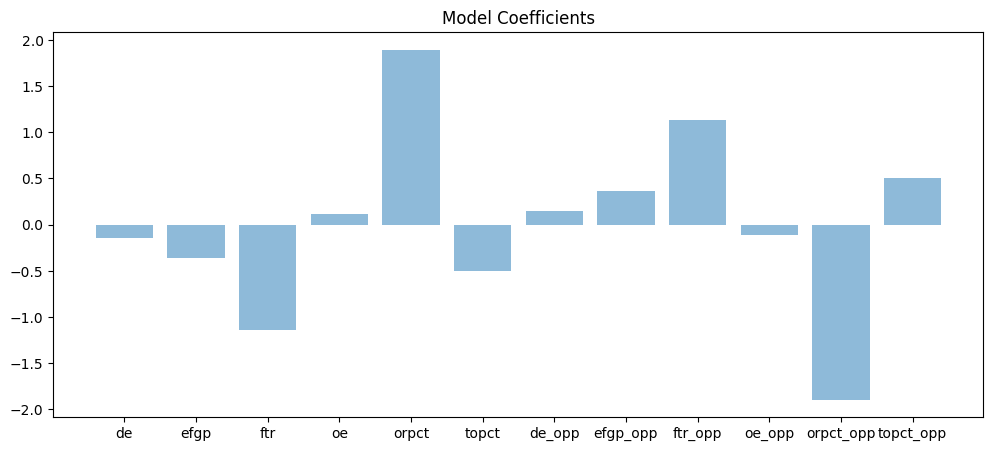

In [53]:

plt.figure(figsize=(12,5))
predictors = ('de', 'efgp', 'ftr', 'oe', 'orpct', 'topct', 'de_opp', 'efgp_opp', 'ftr_opp', 'oe_opp', 'orpct_opp', 'topct_opp')
y_pos = np.arange(len(predictors))
model_coeff = model.coef_.tolist()[0]
 
plt.bar(y_pos, model_coeff, align='center', alpha=0.5, )
plt.xticks(y_pos, predictors)
plt.title('Model Coefficients')
 
plt.show()

In [283]:

C = {'C':[0.1, 1, 10 ,100, 10000, 1000000, 10000000]}
log_model = LogisticRegression(penalty='l2')
clf = GridSearchCV(estimator=log_model, param_grid=C, cv=3, scoring='accuracy')

#Train the model
clf_train = clf.fit(X_train, y_train)

#Predict
clf_pred = clf.predict(X_test)

#Best value of C
print ('Best accuracy of the model:', clf.best_score_) 
print ('Best C:',clf.best_estimator_.C)

Best accuracy of the model: 0.64619369161
Best C: 10


In [284]:
# probability estimates from cross validation model
win_prob = pd.Series(clf.predict_proba(X_test)[:,1])

In [285]:
test_new = test.reset_index()

In [286]:
test_new['win_prob'] = win_prob

In [287]:
test_new = test_new[['team','opp','win_prob','result']]
test_final = pd.merge(test_new,test_new,left_on = ['team','opp'], right_on = ['opp','team'],how = 'left', 
         suffixes = ('_team','_opp'))

In [288]:
test_final[:5]

,team_team,opp_team,win_prob_team,result_team,team_opp,opp_opp,win_prob_opp,result_opp
0,1195,1192,0.69112,1,1192,1195,0.308876,0
1,1195,1192,0.69112,1,1192,1195,0.308876,0
2,1195,1192,0.69112,1,1192,1195,0.308876,0
3,1195,1192,0.69112,1,1192,1195,0.308876,0
4,1195,1192,0.69112,1,1192,1195,0.308876,0


In [289]:
test_final['pred_result'] = 0.0
test_final['pred_result'][test_final['win_prob_team'] > test_final['win_prob_opp']] = 1.0

C:\Users\cslun\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [290]:
test_final['check'] = test_final['result_team']!=test_final['pred_result']
test_final['check'].value_counts()/2

False    483521.0
True     231421.0
Name: check, dtype: float64

# SVM 1

In [35]:
formula = 'result ~ 0 + de + efgp + ftr + oe + orpct + topct + de_opp + efgp_opp + ftr_opp + oe_opp + orpct_opp + topct_opp'

In [36]:
Y_train, X_train = dmatrices(formula, train, return_type='dataframe')
y_train = Y_train['result'].values


Y_test, X_test = dmatrices(formula, test, return_type='dataframe')
y_test = Y_test['result'].values

In [37]:
model = SVC(kernel = 'linear')
result = model.fit(X_train, y_train)

In [38]:
prediction_train = model.predict(X_train)
print (metrics.accuracy_score(y_train, prediction_train))

0.672373081464


In [39]:
prediction = model.predict(X_test)
print (metrics.accuracy_score(y_test, prediction))

0.686567164179


In [40]:

C = {'C':[0.1, 1, 10 ,100, 10000, 1000000, 10000000]}
log_model = LogisticRegression(penalty='l2')
clf = GridSearchCV(estimator=log_model, param_grid=C, cv=3, scoring='accuracy')

#Train the model
clf_train = clf.fit(X_train, y_train)

#Predict
clf_pred = clf.predict(X_test)

#Best value of C
print ('Best accuracy of the model:', clf.best_score_) 
print ('Best C:',clf.best_estimator_.C)

Best accuracy of the model: 0.681227863046
Best C: 10000


In [35]:
# probability estimates from cross validation model
win_prob = pd.Series(clf.predict_proba(X_test)[:,1])

In [36]:
test_new = test.reset_index()

In [37]:
test_new['win_prob'] = win_prob

In [38]:
test_new = test_new[['team','opp','win_prob','result']]
test_final = pd.merge(test_new,test_new,left_on = ['team','opp'], right_on = ['opp','team'],how = 'left', 
         suffixes = ('_team','_opp'))

In [39]:
test_final[:5]

,team_team,opp_team,win_prob_team,result_team,team_opp,opp_opp,win_prob_opp,result_opp
0,1195,1192,0.720273,1,1192,1195,0.279721,0
1,1455,1435,0.764622,1,1435,1455,0.235255,0
2,1221,1380,0.240624,1,1380,1221,0.759330,0
3,1276,1409,0.603964,1,1409,1276,0.396004,0
4,1114,1345,0.341908,1,1345,1114,0.658023,0


In [40]:
test_final['pred_result'] = 0.0
test_final['pred_result'][test_final['win_prob_team'] > test_final['win_prob_opp']] = 1.0

C:\Users\cslun\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [41]:
test_final['check'] = test_final['result_team']!=test_final['pred_result']
test_final['check'].value_counts()/2

False    47.0
True     20.0
Name: check, dtype: float64

## Random Forest 1

In [393]:
formula = 'result ~ 0 + de + efgp + ftr + oe + orpct + topct + de_opp + efgp_opp + ftr_opp + oe_opp + orpct_opp + topct_opp'

In [394]:
Y_train, X_train = dmatrices(formula, train, return_type='dataframe')
y_train = Y_train['result'].values


Y_test, X_test = dmatrices(formula, test, return_type='dataframe')
y_test = Y_test['result'].values

In [418]:
model = RandomForestClassifier(max_depth = 4, n_estimators = 300)
result = model.fit(X_train, y_train)

In [419]:
prediction_train = model.predict(X_train)
print (metrics.accuracy_score(y_train, prediction_train))

0.741440377804


In [420]:
prediction = model.predict(X_test)
print (metrics.accuracy_score(y_test, prediction))

0.626865671642


In [307]:
# returns all probability estimates
probs = model.predict_proba(X_test)
probs

array([[ 0.5,  0.5],
       [ 0.2,  0.8],
       [ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.7,  0.3],
       [ 0.4,  0.6],
       [ 0.4,  0.6],
       [ 0.4,  0.6],
       [ 0.1,  0.9],
       [ 0.3,  0.7],
       [ 0.7,  0.3],
       [ 0.4,  0.6],
       [ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.2,  0.8],
       [ 0.7,  0.3],
       [ 0.6,  0.4],
       [ 0.3,  0.7],
       [ 0.6,  0.4],
       [ 0.3,  0.7],
       [ 0.5,  0.5],
       [ 0.2,  0.8],
       [ 0.7,  0.3],
       [ 0.8,  0.2],
       [ 0.7,  0.3],
       [ 0.6,  0.4],
       [ 0.6,  0.4],
       [ 0.3,  0.7],
       [ 0.8,  0.2],
       [ 0.4,  0.6],
       [ 0.7,  0.3],
       [ 0. ,  1. ],
       [ 0.4,  0.6],
       [ 0.3,  0.7],
       [ 0.8,  0.2],
       [ 0.4,  0.6],
       [ 0.7,  0.3],
       [ 0. ,  1. ],
       [ 0.4,  0.6],
       [ 0.5,  0.5],
       [ 0.3,  0.7],
       [ 0.5,  0.5],
       [ 0.3,  0.7],
       [ 0.3,  0.7],
       [ 0.8,  0.2],
       [ 0.7,  0.3],
       [ 0.5,  0.5],
       [ 0.5,

Feature ranking:
1. feature 6 (0.108210)
2. feature 4 (0.093566)
3. feature 10 (0.092847)
4. feature 0 (0.090329)
5. feature 9 (0.085202)
6. feature 3 (0.081519)
7. feature 7 (0.080942)
8. feature 5 (0.080672)
9. feature 11 (0.076881)
10. feature 1 (0.075932)
11. feature 2 (0.068479)
12. feature 8 (0.065422)


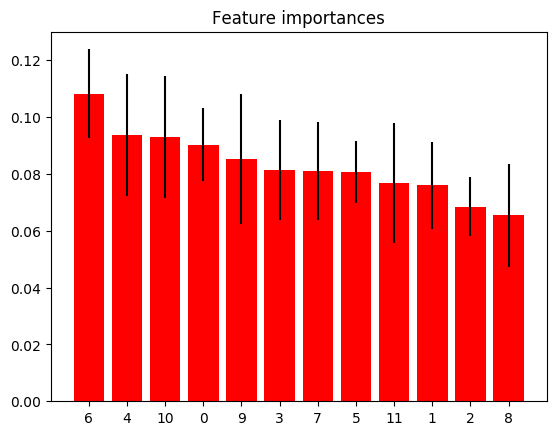

In [308]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# XGBoost 1

In [56]:
formula = 'result ~ 0 + de + efgp + ftr + oe + orpct + topct + de_opp + efgp_opp + ftr_opp + oe_opp + orpct_opp + topct_opp'

In [57]:
Y_train, X_train = dmatrices(formula, train, return_type='dataframe')
y_train = Y_train['result'].values


Y_test, X_test = dmatrices(formula, test, return_type='dataframe')
y_test = Y_test['result'].values

In [58]:
model = XGBClassifier(max_depth = 4, n_estimators = 300)
result = model.fit(X_train, y_train)

In [59]:
prediction_train = model.predict(X_train)
print (metrics.accuracy_score(y_train, prediction_train))

0.979929161747


In [60]:
prediction = model.predict(X_test)
print (metrics.accuracy_score(y_test, prediction))

0.664179104478


In [47]:
# returns all probability estimates
probs = model.predict_proba(X_test)
probs

array([[ 0.25430006,  0.74569994],
       [ 0.13790077,  0.86209923],
       [ 0.60573614,  0.39426386],
       [ 0.28064609,  0.71935391],
       [ 0.63583964,  0.36416036],
       [ 0.33245784,  0.66754216],
       [ 0.46935654,  0.53064346],
       [ 0.39760715,  0.60239285],
       [ 0.27808958,  0.72191042],
       [ 0.38495606,  0.61504394],
       [ 0.62855232,  0.37144771],
       [ 0.0764159 ,  0.9235841 ],
       [ 0.39326841,  0.60673159],
       [ 0.29957044,  0.70042956],
       [ 0.29735494,  0.70264506],
       [ 0.54502356,  0.45497644],
       [ 0.36819619,  0.63180381],
       [ 0.36995494,  0.63004506],
       [ 0.41183251,  0.58816749],
       [ 0.37449491,  0.62550509],
       [ 0.53771305,  0.46228698],
       [ 0.34417099,  0.65582901],
       [ 0.48921084,  0.51078916],
       [ 0.82122833,  0.17877167],
       [ 0.57421172,  0.42578828],
       [ 0.29243827,  0.70756173],
       [ 0.61317807,  0.38682193],
       [ 0.14510393,  0.85489607],
       [ 0.72336143,

Feature ranking:
1. feature 6 (0.108210)
2. feature 4 (0.093566)
3. feature 10 (0.092847)
4. feature 0 (0.090329)
5. feature 9 (0.085202)
6. feature 3 (0.081519)
7. feature 7 (0.080942)
8. feature 5 (0.080672)
9. feature 11 (0.076881)
10. feature 1 (0.075932)
11. feature 2 (0.068479)
12. feature 8 (0.065422)


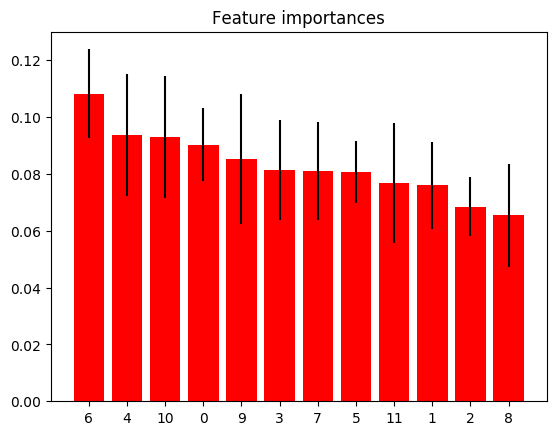

In [308]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# Bagging 1

In [89]:
formula = 'result ~ 0 + de + efgp + ftr + oe + orpct + topct + de_opp + efgp_opp + ftr_opp + oe_opp + orpct_opp + topct_opp'

In [90]:
Y_train, X_train = dmatrices(formula, train, return_type='dataframe')
y_train = Y_train['result'].values


Y_test, X_test = dmatrices(formula, test, return_type='dataframe')
y_test = Y_test['result'].values

In [112]:
model = BaggingClassifier(n_estimators = 30)
result = model.fit(X_train, y_train)

In [113]:
prediction_train = model.predict(X_train)
print (metrics.accuracy_score(y_train, prediction_train))

0.998819362456


In [114]:
prediction = model.predict(X_test)
print (metrics.accuracy_score(y_test, prediction))

0.65671641791


In [88]:
# returns all probability estimates
probs = model.predict_proba(X_test)
probs

array([[ 0.45,  0.55],
       [ 0.2 ,  0.8 ],
       [ 0.55,  0.45],
       [ 0.45,  0.55],
       [ 0.2 ,  0.8 ],
       [ 0.3 ,  0.7 ],
       [ 0.55,  0.45],
       [ 0.55,  0.45],
       [ 0.3 ,  0.7 ],
       [ 0.3 ,  0.7 ],
       [ 0.6 ,  0.4 ],
       [ 0.05,  0.95],
       [ 0.2 ,  0.8 ],
       [ 0.3 ,  0.7 ],
       [ 0.3 ,  0.7 ],
       [ 0.65,  0.35],
       [ 0.4 ,  0.6 ],
       [ 0.1 ,  0.9 ],
       [ 0.45,  0.55],
       [ 0.05,  0.95],
       [ 0.55,  0.45],
       [ 0.25,  0.75],
       [ 0.35,  0.65],
       [ 0.85,  0.15],
       [ 0.6 ,  0.4 ],
       [ 0.4 ,  0.6 ],
       [ 0.5 ,  0.5 ],
       [ 0.35,  0.65],
       [ 0.55,  0.45],
       [ 0.65,  0.35],
       [ 0.35,  0.65],
       [ 0.25,  0.75],
       [ 0.25,  0.75],
       [ 0.25,  0.75],
       [ 0.7 ,  0.3 ],
       [ 0.15,  0.85],
       [ 0.45,  0.55],
       [ 0.55,  0.45],
       [ 0.35,  0.65],
       [ 0.75,  0.25],
       [ 0.45,  0.55],
       [ 0.75,  0.25],
       [ 0.4 ,  0.6 ],
       [ 0.

# Logit Model 2

In [54]:
train['oor'] = train['or'] #needed because 'or' won't work in a formula
test['oor'] = test['or']
formula = 'result ~ 0 + Result + ast + blk + diff + dr + fga + fgm + fgm3 + fgp + fgp3 + fta + ftm + ftp + oppscore + oor + pf + score + stl + to + tr + elo + Result_opp + ast_opp + blk_opp + diff_opp + dr_opp + fga_opp + fgm_opp + fgm3_opp + fgp_opp + fgp3_opp + fta_opp + ftm_opp + ftp_opp + oppscore_opp + or_opp + pf_opp + score_opp + stl_opp + to_opp + tr_opp + elo_opp + de + efgp + ftr + oe + orpct + topct + de_opp + efgp_opp + ftr_opp + oe_opp + orpct_opp + topct_opp'

C:\Users\cslun\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\cslun\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [55]:
Y_train, X_train = dmatrices(formula, train, return_type='dataframe')
y_train = Y_train['result'].values


Y_test, X_test = dmatrices(formula, test, return_type='dataframe')
y_test = Y_test['result'].values

In [56]:
model = LogisticRegression()
result = model.fit(X_train, y_train)

In [57]:
prediction_train = model.predict(X_train)
print (metrics.accuracy_score(y_train, prediction_train))

0.71546635183


In [58]:
prediction = model.predict(X_test)
print (metrics.accuracy_score(y_test, prediction))

0.746268656716


In [59]:
# returns all probability estimates
probs = model.predict_proba(X_test)
probs

array([[ 0.39899096,  0.60100904],
       [ 0.31436487,  0.68563513],
       [ 0.7157    ,  0.2843    ],
       [ 0.31909675,  0.68090325],
       [ 0.79963335,  0.20036665],
       [ 0.22138801,  0.77861199],
       [ 0.19347354,  0.80652646],
       [ 0.31186914,  0.68813086],
       [ 0.40693152,  0.59306848],
       [ 0.11682489,  0.88317511],
       [ 0.28057533,  0.71942467],
       [ 0.01030907,  0.98969093],
       [ 0.11689477,  0.88310523],
       [ 0.06175461,  0.93824539],
       [ 0.01495593,  0.98504407],
       [ 0.48163544,  0.51836456],
       [ 0.2023189 ,  0.7976811 ],
       [ 0.00976822,  0.99023178],
       [ 0.58221953,  0.41778047],
       [ 0.63462753,  0.36537247],
       [ 0.79705191,  0.20294809],
       [ 0.32061579,  0.67938421],
       [ 0.28664759,  0.71335241],
       [ 0.95940679,  0.04059321],
       [ 0.63577836,  0.36422164],
       [ 0.37585992,  0.62414008],
       [ 0.14595756,  0.85404244],
       [ 0.0059792 ,  0.9940208 ],
       [ 0.68188249,

In [60]:
model.coef_

array([[-1.71989565, -0.11539965,  0.04154852,  0.22322791, -0.12821481,
        -0.04016185,  0.05919822, -0.06685012,  0.01410077, -0.33853445,
        -0.13701433,  0.06933141,  0.06045341, -0.10235016,  0.12114128,
         0.03160124,  0.12087775,  0.00180839,  0.03726525, -0.00707353,
         0.00647309,  1.71988607,  0.11557978, -0.04132249, -0.22329028,
         0.1282385 ,  0.04019641, -0.05913589,  0.06667918, -0.01409359,
         0.33853355,  0.13704898, -0.06934545, -0.06044492,  0.10235223,
        -0.12118984, -0.03150507, -0.12093805, -0.00195312, -0.03756882,
         0.00704866, -0.0064752 ,  0.15332825,  0.0162246 , -0.08674096,
        -0.16436049,  0.01217943, -0.01319728, -0.15335745, -0.01621812,
         0.08674477,  0.16445244, -0.01218002,  0.01319353]])

# SVM 2

In [25]:
train['oor'] = train['or'] #needed because 'or' won't work in a formula
test['oor'] = test['or']
formula = 'result ~ 0 + Result + ast + blk + diff + dr + fga + fgm + fgm3 + fgp + fgp3 + fta + ftm + ftp + oppscore + oor + pf + score + stl + to + tr + elo + Result_opp + ast_opp + blk_opp + diff_opp + dr_opp + fga_opp + fgm_opp + fgm3_opp + fgp_opp + fgp3_opp + fta_opp + ftm_opp + ftp_opp + oppscore_opp + or_opp + pf_opp + score_opp + stl_opp + to_opp + tr_opp + elo_opp + de + efgp + ftr + oe + orpct + topct + de_opp + efgp_opp + ftr_opp + oe_opp + orpct_opp + topct_opp'

C:\Users\cslun\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\cslun\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
Y_train, X_train = dmatrices(formula, train, return_type='dataframe')
y_train = Y_train['result'].values


Y_test, X_test = dmatrices(formula, test, return_type='dataframe')
y_test = Y_test['result'].values

In [31]:
model = SVC(kernel = 'linear')
result = model.fit(X_train, y_train)

In [32]:
prediction_train = model.predict(X_train)
print (metrics.accuracy_score(y_train, prediction_train))

0.718417945691


In [33]:
prediction = model.predict(X_test)
print (metrics.accuracy_score(y_test, prediction))

0.738805970149


## Random Forest 2

In [61]:
train['oor'] = train['or'] #needed because 'or' won't work in a formula
test['oor'] = test['or']
formula = 'result ~ 0 + Result + ast + blk + diff + dr + fga + fgm + fgm3 + fgp + fgp3 + fta + ftm + ftp + oppscore + oor + pf + score + stl + to + tr + elo + Result_opp + ast_opp + blk_opp + diff_opp + dr_opp + fga_opp + fgm_opp + fgm3_opp + fgp_opp + fgp3_opp + fta_opp + ftm_opp + ftp_opp + oppscore_opp + or_opp + pf_opp + score_opp + stl_opp + to_opp + tr_opp + elo_opp + de + efgp + ftr + oe + orpct + topct + de_opp + efgp_opp + ftr_opp + oe_opp + orpct_opp + topct_opp'

C:\Users\cslun\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\cslun\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [62]:
Y_train, X_train = dmatrices(formula, train, return_type='dataframe')
y_train = Y_train['result'].values


Y_test, X_test = dmatrices(formula, test, return_type='dataframe')
y_test = Y_test['result'].values

In [63]:
model = RandomForestClassifier(max_depth = 6, n_estimators = 1500)
result = model.fit(X_train, y_train)

In [64]:
prediction_train = model.predict(X_train)
print (metrics.accuracy_score(y_train, prediction_train))

0.865407319953


In [65]:
prediction = model.predict(X_test)
print (metrics.accuracy_score(y_test, prediction))

0.671641791045


In [66]:
# returns all probability estimates
probs = model.predict_proba(X_test)
probs

array([[ 0.49086182,  0.50913818],
       [ 0.435926  ,  0.564074  ],
       [ 0.50916943,  0.49083057],
       [ 0.45853975,  0.54146025],
       [ 0.70138031,  0.29861969],
       [ 0.40675897,  0.59324103],
       [ 0.40637867,  0.59362133],
       [ 0.44598268,  0.55401732],
       [ 0.52597049,  0.47402951],
       [ 0.27519071,  0.72480929],
       [ 0.46922532,  0.53077468],
       [ 0.12035004,  0.87964996],
       [ 0.32450556,  0.67549444],
       [ 0.24276068,  0.75723932],
       [ 0.17799693,  0.82200307],
       [ 0.43604445,  0.56395555],
       [ 0.36636764,  0.63363236],
       [ 0.24012909,  0.75987091],
       [ 0.59910685,  0.40089315],
       [ 0.45317894,  0.54682106],
       [ 0.56245089,  0.43754911],
       [ 0.50191741,  0.49808259],
       [ 0.39741163,  0.60258837],
       [ 0.81784631,  0.18215369],
       [ 0.50814519,  0.49185481],
       [ 0.46161732,  0.53838268],
       [ 0.30399757,  0.69600243],
       [ 0.16500531,  0.83499469],
       [ 0.59173653,

In [67]:
model.feature_importances_

array([ 0.04088952,  0.00942605,  0.01567716,  0.0626727 ,  0.00933942,
        0.01212192,  0.01970781,  0.00906183,  0.01049223,  0.0080806 ,
        0.00742461,  0.00717841,  0.00858809,  0.01383259,  0.00946751,
        0.01030485,  0.01423965,  0.00853444,  0.01039158,  0.01136612,
        0.12656661,  0.0381776 ,  0.00970905,  0.01465413,  0.06669681,
        0.00879755,  0.01050868,  0.01725777,  0.0098402 ,  0.0115234 ,
        0.00816027,  0.00736842,  0.00719611,  0.00912149,  0.01347998,
        0.00937719,  0.01021863,  0.01460445,  0.00893787,  0.01039542,
        0.01139443,  0.12649748,  0.01963731,  0.00865744,  0.00930572,
        0.00986259,  0.01629963,  0.01058266,  0.01919449,  0.00962504,
        0.00976707,  0.01053424,  0.01628699,  0.01096618])

Feature ranking:
1. feature 20 (0.126567)
2. feature 41 (0.126497)
3. feature 24 (0.066697)
4. feature 3 (0.062673)
5. feature 0 (0.040890)
6. feature 21 (0.038178)
7. feature 6 (0.019708)
8. feature 42 (0.019637)
9. feature 48 (0.019194)
10. feature 27 (0.017258)
11. feature 46 (0.016300)
12. feature 52 (0.016287)
13. feature 2 (0.015677)
14. feature 23 (0.014654)
15. feature 37 (0.014604)
16. feature 16 (0.014240)
17. feature 13 (0.013833)
18. feature 34 (0.013480)
19. feature 5 (0.012122)
20. feature 29 (0.011523)
21. feature 40 (0.011394)
22. feature 19 (0.011366)
23. feature 53 (0.010966)
24. feature 47 (0.010583)
25. feature 51 (0.010534)
26. feature 26 (0.010509)
27. feature 8 (0.010492)
28. feature 39 (0.010395)
29. feature 18 (0.010392)
30. feature 15 (0.010305)
31. feature 36 (0.010219)
32. feature 45 (0.009863)
33. feature 28 (0.009840)
34. feature 50 (0.009767)
35. feature 22 (0.009709)
36. feature 49 (0.009625)
37. feature 14 (0.009468)
38. feature 1 (0.009426)
39. feature

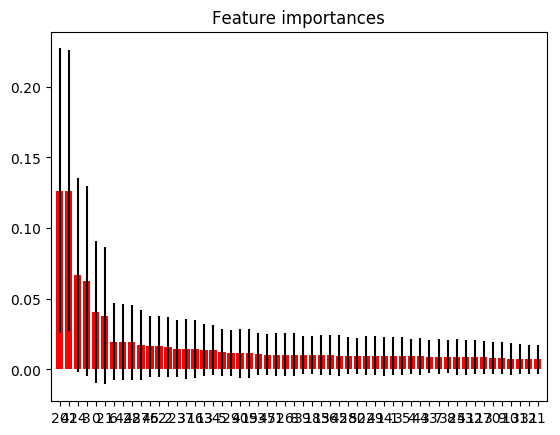

In [68]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# XGBoost 2

In [61]:
train['oor'] = train['or'] #needed because 'or' won't work in a formula
test['oor'] = test['or']
formula = 'result ~ 0 + Result + ast + blk + diff + dr + fga + fgm + fgm3 + fgp + fgp3 + fta + ftm + ftp + oppscore + oor + pf + score + stl + to + tr + elo + Result_opp + ast_opp + blk_opp + diff_opp + dr_opp + fga_opp + fgm_opp + fgm3_opp + fgp_opp + fgp3_opp + fta_opp + ftm_opp + ftp_opp + oppscore_opp + or_opp + pf_opp + score_opp + stl_opp + to_opp + tr_opp + elo_opp + de + efgp + ftr + oe + orpct + topct + de_opp + efgp_opp + ftr_opp + oe_opp + orpct_opp + topct_opp'

C:\Users\cslun\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\cslun\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [62]:
Y_train, X_train = dmatrices(formula, train, return_type='dataframe')
y_train = Y_train['result'].values


Y_test, X_test = dmatrices(formula, test, return_type='dataframe')
y_test = Y_test['result'].values

In [63]:
model = XGBClassifier(max_depth = 4, n_estimators = 300)
result = model.fit(X_train, y_train)

In [64]:
prediction_train = model.predict(X_train)
print (metrics.accuracy_score(y_train, prediction_train))

1.0


In [65]:
prediction = model.predict(X_test)
print (metrics.accuracy_score(y_test, prediction))

0.649253731343


In [66]:
# returns all probability estimates
probs = model.predict_proba(X_test)
probs

array([[  2.52348900e-01,   7.47651100e-01],
       [  6.41561151e-02,   9.35843885e-01],
       [  5.33913732e-01,   4.66086298e-01],
       [  4.87791657e-01,   5.12208343e-01],
       [  9.79313850e-01,   2.06861757e-02],
       [  5.13782263e-01,   4.86217767e-01],
       [  1.16672039e-01,   8.83327961e-01],
       [  8.16557765e-01,   1.83442205e-01],
       [  4.57216144e-01,   5.42783856e-01],
       [  1.94504440e-01,   8.05495560e-01],
       [  7.10334301e-01,   2.89665729e-01],
       [  1.16020441e-03,   9.98839796e-01],
       [  5.15618920e-02,   9.48438108e-01],
       [  1.00648999e-02,   9.89935100e-01],
       [  2.57742405e-03,   9.97422576e-01],
       [  1.13057494e-01,   8.86942506e-01],
       [  1.08635128e-01,   8.91364872e-01],
       [  1.33598447e-02,   9.86640155e-01],
       [  5.60051084e-01,   4.39948946e-01],
       [  6.78107142e-01,   3.21892828e-01],
       [  9.06514406e-01,   9.34855938e-02],
       [  8.06642711e-01,   1.93357304e-01],
       [  

In [67]:
model.feature_importances_

array([ 0.01210526,  0.01947368,  0.01973684,  0.0281579 ,  0.01736842,
        0.01526316,  0.01      ,  0.02052632,  0.02526316,  0.01736842,
        0.01447368,  0.01657895,  0.02184211,  0.01868421,  0.01052632,
        0.01447368,  0.01526316,  0.01947368,  0.01210526,  0.01      ,
        0.04657895,  0.01394737,  0.02578947,  0.02078947,  0.02868421,
        0.01973684,  0.01710526,  0.00921053,  0.01973684,  0.02736842,
        0.0168421 ,  0.01342105,  0.01763158,  0.02342105,  0.02236842,
        0.01105263,  0.02105263,  0.01289474,  0.0168421 ,  0.01342105,
        0.01473684,  0.04394737,  0.01526316,  0.02026316,  0.01552632,
        0.01578947,  0.02315789,  0.01973684,  0.01421053,  0.01394737,
        0.01631579,  0.00921053,  0.02184211,  0.01947368], dtype=float32)

In [55]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

AttributeError: 'XGBClassifier' object has no attribute 'estimators_'

# Bagging 2

In [115]:
train['oor'] = train['or'] #needed because 'or' won't work in a formula
test['oor'] = test['or']
formula = 'result ~ 0 + Result + ast + blk + diff + dr + fga + fgm + fgm3 + fgp + fgp3 + fta + ftm + ftp + oppscore + oor + pf + score + stl + to + tr + elo + Result_opp + ast_opp + blk_opp + diff_opp + dr_opp + fga_opp + fgm_opp + fgm3_opp + fgp_opp + fgp3_opp + fta_opp + ftm_opp + ftp_opp + oppscore_opp + or_opp + pf_opp + score_opp + stl_opp + to_opp + tr_opp + elo_opp + de + efgp + ftr + oe + orpct + topct + de_opp + efgp_opp + ftr_opp + oe_opp + orpct_opp + topct_opp'

C:\Users\cslun\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\cslun\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [116]:
Y_train, X_train = dmatrices(formula, train, return_type='dataframe')
y_train = Y_train['result'].values


Y_test, X_test = dmatrices(formula, test, return_type='dataframe')
y_test = Y_test['result'].values

In [117]:
model = BaggingClassifier(n_estimators = 30)
result = model.fit(X_train, y_train)

In [118]:
prediction_train = model.predict(X_train)
print (metrics.accuracy_score(y_train, prediction_train))

0.999409681228


In [119]:
prediction = model.predict(X_test)
print (metrics.accuracy_score(y_test, prediction))

0.664179104478


In [120]:
# returns all probability estimates
probs = model.predict_proba(X_test)
probs

array([[ 0.43333333,  0.56666667],
       [ 0.33333333,  0.66666667],
       [ 0.46666667,  0.53333333],
       [ 0.5       ,  0.5       ],
       [ 0.86666667,  0.13333333],
       [ 0.3       ,  0.7       ],
       [ 0.46666667,  0.53333333],
       [ 0.46666667,  0.53333333],
       [ 0.8       ,  0.2       ],
       [ 0.13333333,  0.86666667],
       [ 0.6       ,  0.4       ],
       [ 0.16666667,  0.83333333],
       [ 0.3       ,  0.7       ],
       [ 0.13333333,  0.86666667],
       [ 0.1       ,  0.9       ],
       [ 0.26666667,  0.73333333],
       [ 0.36666667,  0.63333333],
       [ 0.26666667,  0.73333333],
       [ 0.66666667,  0.33333333],
       [ 0.73333333,  0.26666667],
       [ 0.76666667,  0.23333333],
       [ 0.6       ,  0.4       ],
       [ 0.36666667,  0.63333333],
       [ 0.86666667,  0.13333333],
       [ 0.53333333,  0.46666667],
       [ 0.53333333,  0.46666667],
       [ 0.23333333,  0.76666667],
       [ 0.06666667,  0.93333333],
       [ 0.73333333,

## Lasso Feature Selection

In [73]:
train['oor'] = train['or'] #needed because 'or' won't work in a formula
test['oor'] = test['or']
formula = 'gamediff ~ 0 + Result + ast + blk + diff + dr + fga + fgm + fgm3 + fgp + fgp3 + fta + ftm + ftp + oppscore + oor + pf + score + stl + to + tr + elo + Result_opp + ast_opp + blk_opp + diff_opp + dr_opp + fga_opp + fgm_opp + fgm3_opp + fgp_opp + fgp3_opp + fta_opp + ftm_opp + ftp_opp + oppscore_opp + or_opp + pf_opp + score_opp + stl_opp + to_opp + tr_opp + elo_opp + de + efgp + ftr + oe + orpct + topct + de_opp + efgp_opp + ftr_opp + oe_opp + orpct_opp + topct_opp'

C:\Users\cslun\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\cslun\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [74]:
Y_train, X_train = dmatrices(formula, train, return_type='dataframe')
y_train = Y_train['gamediff']


Y_test, X_test = dmatrices(formula, test, return_type='dataframe')
y_test = Y_test['gamediff']

In [75]:
model = LinearRegression()
result = model.fit(X_train, y_train)

In [76]:
prediction_train = model.predict(X_train)
sk.metrics.mean_squared_error(y_train,prediction_train)

113.29343171605957

In [77]:
prediction = model.predict(X_test)
sk.metrics.mean_squared_error(y_test,prediction)

134.48276171410706